# Predict climate from berry fungal communities

> using `ritme` (https://github.com/adamovanja/ritme)

note. use the **ritme_model** environment! 


In [3]:
from ritme.find_best_model_config import (
    _load_experiment_config,
    _load_phylogeny,
    _load_taxonomy,
    find_best_model_config,
)
from ritme.split_train_test import _load_data, split_train_test
from ritme.evaluate_tuned_models import evaluate_tuned_models

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mlflow
import numpy as np

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
workdir = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/climate-berries'
%cd $workdir

/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/climate-berries


In [5]:
# set experiment configuration path - this is downloaded from the github repo
# here we specify the column to be stratified by and the target! 
model_config_path = "/home/lfloerl/microterroir/Microbiome/Other_scripts/config/r_local_linreg_py_noGroup.json"
#model_config_path = "/home/lfloerl/microterroir/Microbiome/Other_scripts/config/r_local_linreg_py.json"


# define path to feature table, metadata, and taxonomy (no phylogeny)
path_to_ft = "climate_filtered_table.qza"
path_to_md = "/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Climate.tsv"
path_to_tax = "/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/taxonomy.qza"

# define train size
train_size = 0.8

In [6]:
config = _load_experiment_config(model_config_path)

## Read & split data


In [47]:
md, ft = _load_data(path_to_md, path_to_ft)
print(md.shape, ft.shape)

(595, 36) (326, 6091)


In [48]:
train_val, test = split_train_test(
    md,
    ft,
    group_by_column=config["group_by_column"],
    train_size=train_size,
    seed=config["seed_data"],
)

Train: (260, 6127), Test: (66, 6127)


/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/ritme/split_train_test.py:139: UserWarning: Provided feature table contains absolute instead of relative abundances. Hence, converting it to relative abundances...
  warnings.warn(


## Find best model config

View the results with navigating to the folder in the terminal (e.g. `cd /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/climate-berries/ritme_all_models`) and launching  mlflow (`mlflow ui --port 8080`) and opening _http://localhost:8080_ 


**Try different configs** (`experiment_tag`)
* `all_models_v4` --> Train: (278, 6127), Test: (48, 6127)
    * "linreg", "xgb", "rf" 
    * split train/test by 'Year', seed 14 (larger test set)
    * test_mode = true (use entire search space)
    * 37 min
    

* `all_models_noGroup` --> Train: (260, 6127), Test: (66, 6127)
    * "linreg", "xgb", "rf" 
    * no grouping, seed 14 (larger test set)
    * test_mode = true (use entire search space)



In [49]:
tax = _load_taxonomy(path_to_tax)

best_model_dict, path_to_exp = find_best_model_config(
    config, train_val, tax, path_store_model_logs="ritme_linreg_xgb_rf")

2025-02-24 16:06:37,508	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.602 s, which may be a performance bottleneck.
2025-02-24 16:06:37,509	WARNING util.py:201 -- The `process_trial_result` operation took 3.604 s, which may be a performance bottleneck.
2025-02-24 16:06:37,510	WARNING util.py:201 -- Processing trial results took 3.604 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-24 16:06:37,511	WARNING util.py:201 -- The `process_trial_result` operation took 3.605 s, which may be a performance bottleneck.
2025-02-24 16:06:45,906	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.695 s, which may be a performance bottleneck.
2025-02-24 16:06:45,908	WARNING util.py:201 -- The `process_trial_result` operation took 3.697 s, which may be a performance bottleneck.
2025-02-24 16:06:45,909	WARNING util.py:201 -- Processing trial results took 3.697 s, which may be a performance bott

## Evaluate best models

**Key Metrics** for Model Assessment
1. Root Mean Square Error (RMSE)
    * Measures the standard deviation of the residuals (prediction errors)
    * Lower values indicate better performance
2. R-squared (R2)
    * Represents the proportion of variance in the dependent variable explained by the model
    * Higher values indicate better performance


We compare these metrics for the **training and test set** to 
* evaluate the model fit
* Detect overfitting: A significant discrepancy between training and test set performance can indicate overfitting. If the model performs much better on the training set than the test set, it may have memorized the training data rather than learning generalizable patterns
* Compare model stability: Consistent performance across both sets suggests a stable model that generalizes well

In [11]:
metrics = evaluate_tuned_models(best_model_dict, config, train_val, test)
metrics

NameError: name 'best_model_dict' is not defined

# Visualizations

In [7]:
# specify the location of the MLruns files 
log_folder_location = "/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/climate-berries/ritme_linreg_xgb_rf/mlruns"

mlflow.set_tracking_uri(log_folder_location)

df_all_runs = mlflow.search_runs(
    order_by=["metrics.rmse_val ASC"], search_all_experiments=True)

In [8]:
# save output
#df_all_runs.to_csv('MLflow_output.csv')

In [9]:
df_metrics = df_all_runs[['tags.trial_name', "params.data_transform", "params.data_aggregation", "params.data_selection", "params.model", 'metrics.r2_train', 'metrics.rmse_train', 'metrics.r2_val', 'metrics.rmse_val' ]]
df_metrics.tail()

,tags.trial_name,params.data_transform,params.data_aggregation,params.data_selection,params.model,metrics.r2_train,metrics.rmse_train,metrics.r2_val,metrics.rmse_val
1795,train_xgb_ffd22164,clr,tax_order,variance_ith,xgb,0.961599,0.176157,-25.858849,1.349660
1796,train_rf_b59c5913,clr,tax_family,abundance_topi,rf,0.829216,0.371494,-28.593032,1.416691
1797,train_linreg_e4af9cf4,clr,tax_genus,abundance_quantile,linreg,0.999349,0.022936,-30.187377,1.454353
1798,train_linreg_d2bd8c0b,ilr,None,variance_ith,linreg,0.765672,0.435153,-32.192373,1.500374
1799,train_linreg_241e6cef,ilr,None,variance_ith,linreg,0.779301,0.422308,-32.639851,1.510454


/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/lfloerl/.condaenvs/ri

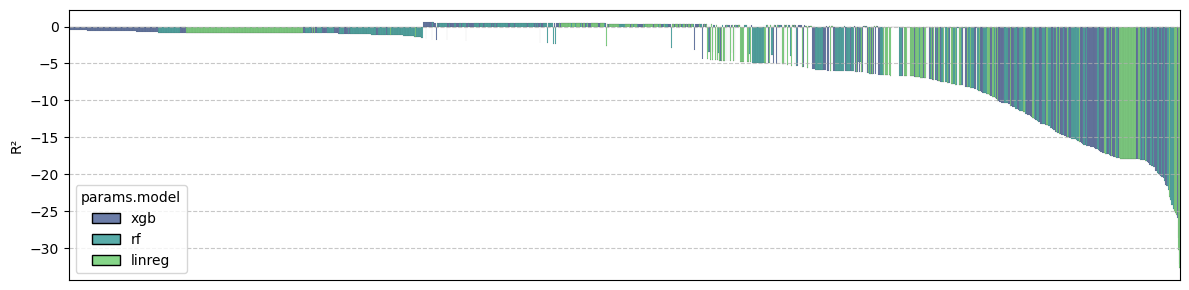

In [61]:
plt.figure(figsize=(12, 3))
sns.histplot(
    data=df_metrics,
    x=df_metrics.index,
    weights=df_metrics["metrics.r2_val"],
    bins=len(df_metrics),  
    hue=df_metrics["params.model"],
    #palette=model_colors,
    palette='viridis',
    element="bars",
    multiple="stack"  
)

plt.xlim(df_metrics.index.min(), df_metrics.index.max())
plt.xlabel("")
plt.ylabel("R²")
plt.xticks([], [])  # Hide x-axis labels
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show legend

plt.tight_layout()
#plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/RITME-test-R2.png', dpi=1000)
plt.show()

/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/lfloerl/.condaenvs/ri

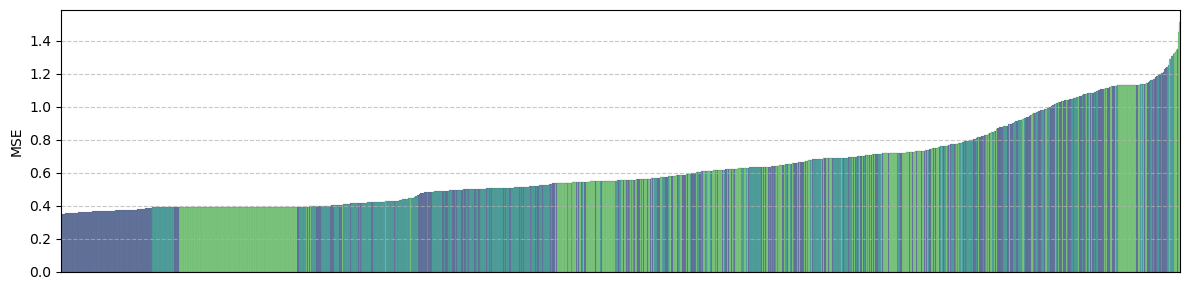

In [62]:
plt.figure(figsize=(12, 3))
sns.histplot(
    data=df_metrics,
    x=df_metrics.index,
    weights=df_metrics["metrics.rmse_val"],
    bins=len(df_metrics),  
    hue=df_metrics["params.model"],
    #palette=model_colors,
    palette='viridis',
    element="bars",
    multiple="stack"  
)

plt.xlim(df_metrics.index.min(), df_metrics.index.max())
plt.xlabel("")
plt.ylabel("MSE")
plt.xticks([], [])  # Hide x-axis labels
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.legend([], [], frameon=False)

plt.tight_layout()
#plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/RITME-test-MSE.png', dpi=1000)
plt.show()

# Extracting trained best models
Get best models for further usage

The best models are stored in Python dictionary best_model_dict with model_type as keys and TunedModel objects as values. To extract a given best model and perform predictions with it, see below code excerpt:

In [10]:
# get best linreg model
best_linreg_model = best_model_dict["linreg"]
best_linreg_model

NameError: name 'best_model_dict' is not defined

In [ ]:
# perform prediction with best linreg model
test_predictions = best_linreg_model.predict(test, "test")
train_predictions = best_linreg_model.predict(train_val, "train")

In [ ]:
if path_to_store_best_models is not None:
    print(f"Saving best models to {path_to_store_best_models}...")
    if not os.path.exists(path_to_store_best_models):
        os.makedirs(path_to_store_best_models)

    save_best_models(best_model_dict, path_to_store_best_models)